In [2]:
%pip install numpy
%pip install bs4
%pip install scikit-optimize
%pip install line_profiler
%pip install sklearn
%pip install shap
%pip install SALib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
np.bool = np.bool_
import shap


def shap_feature_importance(X, y):
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap_sum = np.abs(shap_values).mean(axis=0)
    shap_importance = pd.DataFrame({'Feature': X.columns, 'SHAP Importance': shap_sum})
    shap_importance = shap_importance.sort_values(by='SHAP Importance', ascending=False)
    return shap_importance

# 2. Random Forest Feature Importance
def random_forest_feature_importance(X, y):
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    rf_importance = pd.DataFrame({'Feature': X.columns, 'RF Importance': model.feature_importances_})
    rf_importance = rf_importance.sort_values(by='RF Importance', ascending=False)
    return rf_importance

# 3. L1 Regularization (Lasso) Feature Importance
def lasso_feature_importance(X, y):
    model = Lasso(alpha=0.00001, max_iter=10000)
    model.fit(X, y)
    lasso_importance = pd.DataFrame({'Feature': X.columns, 'Lasso Coefficient': np.abs(model.coef_)})
    lasso_importance = lasso_importance.sort_values(by='Lasso Coefficient', ascending=False)
    return lasso_importance

# 4. Permutation Feature Importance
def permutation_feature_importance(X, y):
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Permutation Importance': perm_importance.importances_mean})
    perm_importance_df = perm_importance_df.sort_values(by='Permutation Importance', ascending=False)
    return perm_importance_df

# 5. Gradient Boosting Feature Importance
def gradient_boosting_feature_importance(X, y):
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X, y)
    gb_importance = pd.DataFrame({'Feature': X.columns, 'GB Importance': model.feature_importances_})
    gb_importance = gb_importance.sort_values(by='GB Importance', ascending=False)
    return gb_importance

In [7]:
def remove_symbols_from_file(file_path, symbols_to_remove):
    with open(file_path, 'r') as file:
        content = file.read()
    
    for symbol in symbols_to_remove:
        content = content.replace(symbol, '')
    
    return content

file_path = 'optimals.txt'
symbols_to_remove = ['[', ']']
cleaned_content = remove_symbols_from_file(file_path, symbols_to_remove)
print(cleaned_content)

with open(file_path, 'w') as file:
    file.write(cleaned_content)

2, 48, 1181, 29, 831, 93, 6, 43, 20, 24.289581174855307, 4, 288.3591594158186, -1, 1, 999, 1008, -1, -5, 234.7343779256768, 7, 998, 4990, 62.58982459565475, 92, -1, 65, -8, 1001, 998, 0, 8, 28.230809441377023, 100009, 14.485980963283726, -9, 3, 263, 16.157311022755003, 3.448688945577634, 24.555391140089323, -9, 4.324289358035942, 117.0401155731376, 5188.536236962801, 4896.3758861977885, 7, 995, 1.1098892966242446, -7, -1, 44.530012061321884, 1.5583905947023584, -6, 36.93107123530575, 23.104162608755843, 4.588390302646103, 105.7689797618358, 1.776006716165636, 3.9396267593849, 1.3684506434052404, 8.88094644804382, 6.016818106346072, 1.4878208917034408, 14.63421988894579, 1, 120, 8.744771036647476, 0, 4.11784340970618, 27, -2, 4, 0, 14.134034725693226, 5.334565845289627, 3.7061503126310873, 0, 2, 6, -6, 70.9524374827075, 2.610187531691542, 5, 0.785787936056229, -1, 4, 19991, 33.84124517330369, 29, 3.518482961542392, 2095.450352591996, 1.522693477741129, 200, 0, 16, 15, 14.634734648302612

In [19]:
from sklearn import preprocessing

X = pd.read_csv('optimals.txt')
X.columns = [f'feature_{i}' for i in range(X.shape[1])]
y = pd.read_csv('scores.txt')
y.columns = ['score (TPS)']

x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)

X.head()

FileNotFoundError: [Errno 2] No such file or directory: 'optimals.txt'

In [ ]:
y.head()

,score (TPS)
0,401.850
1,400.600
2,399.250
3,394.625


In [9]:
df = shap_feature_importance(X, y)
df.head(30)

top_30_features = df['Feature'].head(30).tolist()
top_30_features

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


[0,
 61,
 89,
 88,
 87,
 86,
 85,
 84,
 83,
 82,
 81,
 80,
 79,
 78,
 77,
 76,
 75,
 74,
 73,
 72,
 71,
 70,
 69,
 68,
 67,
 66,
 65,
 64,
 63,
 90]

In [7]:
df = random_forest_feature_importance(X, y.to_numpy())
df.head(30)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,Feature,RF Importance
58,58,0.044336
114,114,0.030425
41,41,0.029956
7,7,0.029738
84,84,0.028820
23,23,0.027173
53,53,0.025007
47,47,0.020744
40,40,0.020408
88,88,0.020332


In [8]:
df = lasso_feature_importance(X, y)
df.head(30)

,Feature,Lasso Coefficient
0,0,6.537061
2,2,2.591183
4,4,1.493673
1,1,1.093908
5,5,0.403856
9,9,0.337281
7,7,0.242856
8,8,0.214362
10,10,0.143019
12,12,0.124528


In [9]:
df = permutation_feature_importance(X, y)
df.head(30)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,Feature,Permutation Importance
114,114,0.019399
23,23,0.018594
7,7,0.017209
84,84,0.016880
109,109,0.016710
88,88,0.016681
101,101,0.016531
41,41,0.016187
97,97,0.015349
120,120,0.014712


In [10]:
df = gradient_boosting_feature_importance(X, y)
df.head(30)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


,Feature,GB Importance
20,20,0.181924
17,17,0.136471
71,71,0.110541
96,96,0.089538
0,0,0.087610
5,5,0.062774
110,110,0.047584
36,36,0.038543
97,97,0.031229
79,79,0.025289


In [4]:
X = pd.read_csv('../artefacts_copy/BO_initial_X', header=None)
X.columns = ['feature_' + str(i) for i in range(X.shape[1])]
X = X.iloc[:, :-1]

y = pd.read_csv('../artefacts_copy/BO_initial_Y', header=None)
y.columns = ['target']

In [5]:
X.to_numpy().shape, y.to_numpy().shape

((323, 317), (323, 1))

In [6]:
import GPyOpt
from domain import read_configs, controllable_params, transform_domain
from globals import set_model_type

set_model_type('BO')

read_configs([
        "../networks/configtx/configtx.yaml",
        "../networks/compose/docker/peercfg-org1/core.yaml",
        "../networks/compose/docker/peercfg-org2/core.yaml",
        "../networks/compose/docker/peercfg-org3/core.yaml",
        "../networks/compose/docker/peercfg-org4/core.yaml",
        # "../networks/compose/docker/ordcfg/orderer.yaml",
])

print(controllable_params)
print(len(controllable_params))

Setting model type to: BO
[{'name': 'Orderer.BatchSize.AbsoluteMaxBytes|MB', 'type': 'discrete', 'bounds': (63, 122), 'config idx': 0, 'default value': 99}, {'name': 'Orderer.BatchSize.MaxMessageCount', 'type': 'discrete', 'bounds': (7, 18), 'config idx': 0, 'default value': 10}, {'name': 'Orderer.BatchSize.PreferredMaxBytes|KB', 'type': 'discrete', 'bounds': (357, 668), 'config idx': 0, 'default value': 512}, {'name': 'Orderer.BatchTimeout|s', 'type': 'discrete', 'bounds': (0, 5), 'config idx': 0, 'default value': 2}, {'name': 'Profiles.ChannelUsingRaft.Orderer.BatchSize.AbsoluteMaxBytes|MB', 'type': 'discrete', 'bounds': (63, 122), 'config idx': 0, 'default value': 99}, {'name': 'Profiles.ChannelUsingRaft.Orderer.BatchSize.MaxMessageCount', 'type': 'discrete', 'bounds': (7, 18), 'config idx': 0, 'default value': 10}, {'name': 'Profiles.ChannelUsingRaft.Orderer.BatchSize.PreferredMaxBytes|KB', 'type': 'discrete', 'bounds': (357, 668), 'config idx': 0, 'default value': 512}, {'name': '

In [7]:
X = X.iloc[:, :6]
controllable_params = controllable_params[:6]
print(len(controllable_params))
controllable_params

6


[{'name': 'Orderer.BatchSize.AbsoluteMaxBytes|MB',
  'type': 'discrete',
  'bounds': (63, 122),
  'config idx': 0,
  'default value': 99},
 {'name': 'Orderer.BatchSize.MaxMessageCount',
  'type': 'discrete',
  'bounds': (7, 18),
  'config idx': 0,
  'default value': 10},
 {'name': 'Orderer.BatchSize.PreferredMaxBytes|KB',
  'type': 'discrete',
  'bounds': (357, 668),
  'config idx': 0,
  'default value': 512},
 {'name': 'Orderer.BatchTimeout|s',
  'type': 'discrete',
  'bounds': (0, 5),
  'config idx': 0,
  'default value': 2},
 {'name': 'Profiles.ChannelUsingRaft.Orderer.BatchSize.AbsoluteMaxBytes|MB',
  'type': 'discrete',
  'bounds': (63, 122),
  'config idx': 0,
  'default value': 99},
 {'name': 'Profiles.ChannelUsingRaft.Orderer.BatchSize.MaxMessageCount',
  'type': 'discrete',
  'bounds': (7, 18),
  'config idx': 0,
  'default value': 10}]

In [8]:
X.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5
0,115.0,13.0,368.0,4.0,114.0,13.0
1,122.0,17.0,430.0,4.0,88.0,14.0
2,71.0,15.0,490.0,4.0,109.0,12.0
3,103.0,18.0,372.0,5.0,65.0,18.0
4,73.0,13.0,510.0,5.0,73.0,13.0


In [11]:
import random

def fit(X):
    print("FIT")
    raise Exception("BO fit")
    return random.uniform(400, 500)

opt = GPyOpt.methods.BayesianOptimization(
            f=fit,
            domain=transform_domain(controllable_params),
            acquisition_type='EI',
            maximize=True,
            initial_design_numdata=0,
            normalize_Y=True,
            num_cores=12,
            X=X.to_numpy(),
            Y=y.to_numpy(),
        )

In [12]:
opt._update_model()

In [13]:
opt.run_optimization(max_iter=0, verbosity=True)

In [14]:
from SALib import ProblemSpec
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import time

problem = {
    'num_vars': X.shape[1],
    'names': X.columns.tolist(),
    'bounds': [item['bounds'] for item in controllable_params],
}

param_values = saltelli.sample(problem, 128, calc_second_order=True)

# print(model.predict(param_values))
# print(len(model.predict(param_values)))
print(len(param_values))
print("delimite")
# sp.set_results(model.predict(sp.samples))
# sp.analyze_sobol()

# print(param_values)
prediction = opt.model.model.predict(param_values)
print(prediction)

1792
delimite
(array([[-1.46477225e-55],
       [ 6.36184028e-36],
       [-1.10231437e-55],
       ...,
       [ 1.41449224e-41],
       [-1.33890958e-29],
       [-4.53878672e-40]]), array([[1.00000027],
       [1.00000027],
       [1.00000027],
       ...,
       [1.00000027],
       [1.00000027],
       [1.00000027]]))


In [15]:
prediction[0]

array([[-1.46477225e-55],
       [ 6.36184028e-36],
       [-1.10231437e-55],
       ...,
       [ 1.41449224e-41],
       [-1.33890958e-29],
       [-4.53878672e-40]])

In [16]:
prediction[1]

array([[1.00000027],
       [1.00000027],
       [1.00000027],
       ...,
       [1.00000027],
       [1.00000027],
       [1.00000027]])

In [17]:
Y_predicted = np.array([item[0] for item in prediction[0]])
Y_predicted

array([-1.46477225e-55,  6.36184028e-36, -1.10231437e-55, ...,
        1.41449224e-41, -1.33890958e-29, -4.53878672e-40])

In [18]:
min(Y_predicted), max(Y_predicted), np.mean(Y_predicted), np.std(Y_predicted)

(-1.6558513987246126e-07,
 1.1470969624393546e-09,
 -2.425571407842587e-10,
 5.505964382816724e-09)

In [14]:
# opt.model.model.normalizer.normalize
# (Y * self.std) + self.mean
# opt.model.model.normalizer.std
opt.model.model.Y

ObsAr([[-1.77995036],
       [-0.23332958],
       [-0.23617002],
       [ 0.31913643],
       [-0.56140065],
       [-0.65797569],
       [ 1.31897209],
       [ 1.68822958],
       [ 0.04929442],
       [ 0.3773655 ],
       [ 0.56341446],
       [-0.29439908],
       [ 1.30334966],
       [-0.50601203],
       [ 0.19983786],
       [-0.81846067],
       [ 1.23801949],
       [ 1.72515532],
       [ 0.43985523],
       [ 2.22649337],
       [ 0.23960405],
       [-0.46056495],
       [ 0.94403372],
       [ 1.43543022],
       [ 0.62732441],
       [-0.07000415],
       [-0.07000415],
       [-0.58270397],
       [-0.20066449],
       [ 0.15155034],
       [ 0.90284731],
       [ 0.85313957],
       [-0.04728061],
       [ 0.83041603],
       [ 0.34043975],
       [ 0.92699106],
       [-0.1410152 ],
       [-0.60684773],
       [ 0.57761667],
       [ 0.89148554],
       [ 0.26658825],
       [-0.63951281],
       [ 0.25096582],
       [-0.1608983 ],
       [ 0.48388208],
       [-0

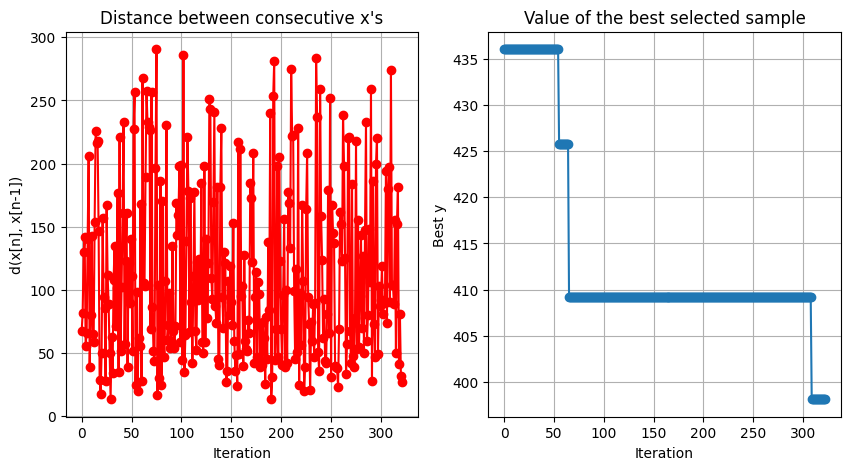

In [40]:
opt.plot_convergence(filename='convergence')

In [136]:
opt.model.model

GP_regression.,value,constraints,priors
Mat52.variance,0.2921774440802549,+ve,
Mat52.lengthscale,4.8293691584400475,+ve,
Gaussian_noise.variance,0.565115426848668,"1e-09,1000000.0",


In [ ]:
Si = sobol.analyze(problem, Y_predicted, print_to_console=True, parallel=True, n_processors=6)
print(Si['S1'])
print(Si['ST'])
sobol_df = pd.DataFrame({
        'Feature': problem['names'],
        'ST': Si['ST']
        
    }).sort_values(by='ST', ascending=False)
sobol_df.reset_index(inplace=True)
sobol_df.head(50)

              ST  ST_conf
feature_0    0.0      0.0
feature_1    0.0      0.0
feature_2    0.0      0.0
feature_3    0.0      0.0
feature_4    0.0      0.0
...          ...      ...
feature_312  0.0      0.0
feature_313  0.0      0.0
feature_314  0.0      0.0
feature_315  0.0      0.0
feature_316  0.0      0.0

[317 rows x 2 columns]
              S1  S1_conf
feature_0    0.0      0.0
feature_1    0.0      0.0
feature_2    0.0      0.0
feature_3    0.0      0.0
feature_4    0.0      0.0
...          ...      ...
feature_312  0.0      0.0
feature_313  0.0      0.0
feature_314  0.0      0.0
feature_315  0.0      0.0
feature_316  0.0      0.0

[317 rows x 2 columns]
                             S2  S2_conf
(feature_0, feature_1)      0.0      NaN
(feature_0, feature_2)      0.0      NaN
(feature_0, feature_3)      0.0      NaN
(feature_0, feature_4)      0.0      NaN
(feature_0, feature_5)      0.0      NaN
...                         ...      ...
(feature_313, feature_315)  0.0      NaN


,index,Feature,ST
0,0,feature_0,0.0
1,209,feature_209,0.0
2,216,feature_216,0.0
3,215,feature_215,0.0
4,214,feature_214,0.0
5,213,feature_213,0.0
6,212,feature_212,0.0
7,211,feature_211,0.0
8,210,feature_210,0.0
9,208,feature_208,0.0


In [12]:
sobol_df = pd.DataFrame({
        'Feature': problem['names'],
        'S1': sp.analysis['S1'],
        'ST': sp.analysis['ST']
    }).sort_values(by='ST', ascending=False)

sobol_df.head(30)

,Feature,S1,ST
79,79,0.147611,0.136679
6,6,0.067073,0.101124
33,33,0.089799,0.094784
38,38,0.059405,0.055360
67,67,0.058858,0.050835
85,85,0.045522,0.047547
28,28,0.042578,0.040005
89,89,0.023793,0.032282
46,46,0.032236,0.031603
53,53,0.033593,0.028782


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X, y)

loadings = pd.DataFrame(
        np.abs(pca.components_),
        columns=X.columns
    )

explained_variance = pca.explained_variance_ratio_
weighted_loadings = loadings.multiply(explained_variance, axis=0)
importance_scores = weighted_loadings.sum(axis=0).sort_values(ascending=False)

results = pd.DataFrame({
    'Feature': importance_scores.index,
    'Importance': importance_scores.values
}).reset_index(drop=True)

results.head(30)

,Feature,Importance
0,118,0.086753
1,86,0.086143
2,34,0.085585
3,109,0.083826
4,119,0.082628
5,18,0.082149
6,81,0.081765
7,31,0.081156
8,13,0.080372
9,51,0.079751


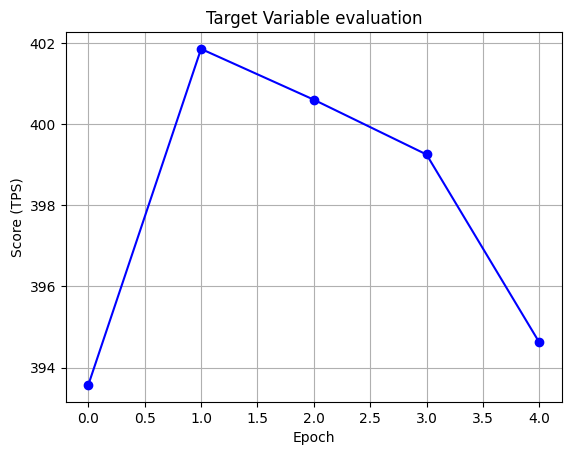

In [15]:
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt

# Plot the scores
# Read array from file
data = np.loadtxt('scores.txt')

# Plot the data
plt.plot(range(len(data)), data, marker='o', linestyle='-', color='b')
# plt.plot(y.index, y['score (TPS)'], marker='o', linestyle='-', color='b')
plt.title('Target Variable evaluation')
plt.xlabel('Epoch')
plt.ylabel('Score (TPS)')
plt.grid(True)
plt.show()